<div style="text-align:center;"><span style="font-size: 2em; font-weight:bold">Prueba técnica Data Science Hackatón Salón Ocupación<br>
Algoritmos de Aprendizaje Supervisado: Clasificación<br>
Predicción sobre el turno en el que se producen acidentes de transito en Barcelona</span></div>

**OBJETIVO: crear un modelo que a partir de suministrarle un mes del año, un día de la semana y un barrio de Barcelona, este puede predecir si hay más posibilidades de que se produzca un accidente en el turno**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


# Analisis y limpieza de datos

Los datos que analizaremos son los existentes entre 2021 y 2023. Están organizados por años, por lo que se carga cada año y se concatenen los mismo para crear un solo Data Frame

In [2]:
# Lista de nombres de archivos CSV
archivos = ['2023_accidents_causa_conductor_gu_bcn_.csv', '2022_accidents_causa_conductor_gu_bcn_.csv', 
            '2021_accidents_causa_conductor_gu_bcn_.csv']

# Lista para almacenar los DataFrames
dfs = []

# Leer cada archivo CSV y almacenar los DataFrames resultantes en la lista 'dfs'
for archivo in archivos:
    df = pd.read_csv(archivo, sep=',')
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
df = pd.concat(dfs, ignore_index=True)

# Mostrar información sobre el DataFrame resultante
df

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,...,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84,Longitud,Latitud
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,...,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783,NaN,NaN
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,...,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598,NaN,NaN
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,...,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783,NaN,NaN
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,...,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762,NaN,NaN
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,...,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27191,2021S000531,8,Nou Barris,45,Porta,242000,Ciutat de Mallorca,0024 0024,Dimarts,2021,...,2,16,Tarda,Desobeir semàfor,431470.52,4587354.60,NaN,NaN,2.178644,41.432989
27192,2021S004840,8,Nou Barris,44,Vilapicina i la Torre Llobeta,119003,Fabra i Puig,0181 0181,Divendres,2021,...,3,0,Nit,Desobeir altres senyals,431371.64,4587040.12,NaN,NaN,2.177496,41.430148
27193,2021S004824,8,Nou Barris,45,Porta,256401,Pintor Alsamora,0001 0001,Dijous,2021,...,2,8,Matí,Manca d'atenció a la conducció,431781.49,4587486.66,NaN,NaN,2.182351,41.434205
27194,2021S005061,8,Nou Barris,44,Vilapicina i la Torre Llobeta,266100,Prat d'en Roquer,0009 0013,Dilluns,2021,...,13,13,Matí,Manca d'atenció a la conducció,431325.36,4586527.80,NaN,NaN,2.177001,41.425530


In [3]:
df.columns

Index(['Numero_expedient', 'Codi_districte', 'Nom_districte', 'Codi_barri',
       'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal ',
       'Descripcio_dia_setmana', 'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes',
       'Hora_dia', 'Descripcio_torn', 'Descripcio_causa_mediata',
       'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 'Longitud_WGS84',
       'Latitud_WGS84', 'Longitud', 'Latitud'],
      dtype='object')

## Detalle de las columna

- Numero_expediente: Número de expediente
- Codi_districte: Código de distrito
- Nom_districte: Nombre del distrito
- Codi_barri: Código de barrio
- Nom_barri: Nombre del barrio
- Codi_carrer: Código de calle
- Nom_carrer: Nombre de la calle
- Num_postal: Número postal
- Descripción_dia_semana: Nombre del día de la semana
- NK_Any: Año
- Mes_any: Mes del año
- Nom_mes: Nombre del mes
- Dia_mes: Día del mes
- Hora_dia: Hora del día
- Descripcio_torn: Descripción del turno
- Descripcio_causa_mediata: Descripción de la causa mediata
- Coordenada_UTM_X_ED50: Coordenada X en formato UTM (ED50)
- Coordenada_UTM_Y_ED50: Coordenada Y en formato UTM (ED50)
- Longitud_WGS84: Longitud
- Latitud_WGS84: Latitud

## Seleccion de los datos

### datos geográficos

Columnas vinculadas con la delimitación espacial donde suceden los accidentes:
- Codi_districte: Código de distrito
- Nom_districte: Nombre del distrito
- Codi_barri: Código de barrio
- Nom_barri: Nombre del barrio
- Codi_carrer: Código de calle
- Nom_carrer: Nombre de la calle
- Num_postal: Número postal
- Coordenada_UTM_X_ED50: Coordenada X en formato UTM (ED50)
- Coordenada_UTM_Y_ED50: Coordenada Y en formato UTM (ED50)
- Longitud_WGS84: Longitud
- Latitud_WGS84: Latitud

In [4]:
# Ver cuales son los distritos

df['Nom_districte'].unique()

array(['Desconegut', 'Sant Martí', 'Ciutat Vella', 'Eixample',
       'Sants-Montjuïc', 'Les Corts', 'Sarrià-Sant Gervasi', 'Gràcia',
       'Horta-Guinardó', 'Nou Barris', 'Sant Andreu'], dtype=object)

In [5]:
# Ver cuales son los barrios

df['Nom_barri'].unique()

array(['Desconegut', "el Camp de l'Arpa del Clot", 'el Clot',
       'Sant Martí de Provençals', 'el Besòs i el Maresme',
       'la Verneda i la Pau', 'Provençals del Poblenou', 'el Poblenou',
       'Diagonal Mar i el Front Marítim del Poblenou',
       'el Parc i la Llacuna del Poblenou', 'el Raval',
       'la Vila Olímpica del Poblenou', 'el Barri Gòtic',
       'Sant Pere, Santa Caterina i la Ribera', 'la Barceloneta',
       'Sant Antoni', "la Nova Esquerra de l'Eixample",
       "l'Antiga Esquerra de l'Eixample", "la Dreta de l'Eixample",
       'la Sagrada Família', 'el Fort Pienc', 'el Poble-sec',
       'la Marina del Prat Vermell', 'la Marina de Port', 'Hostafrancs',
       'la Bordeta', 'la Font de la Guatlla', 'Sants', 'Sants - Badal',
       'les Corts', 'la Maternitat i Sant Ramon',
       'Sant Gervasi - Galvany', 'Pedralbes', 'Sarrià', 'les Tres Torres',
       'Sant Gervasi - la Bonanova', 'el Putxet i el Farró',
       'Vallvidrera, el Tibidabo i les Planes',
      

In [6]:
# Ver cuales son las calle

df['Nom_carrer'].unique()

array(['Rovira (ascendent)                                ',
       'Estatut de Catalunya                              ',
       'Amílcar                                           ', ...,
       'Batllori', 'Mir', "Prat d'en Roquer"], dtype=object)

In [7]:
# Ver cuales son codigos postales (NOTA: el registro tiene un error y hay un espacio después del nombre)

df['Num_postal '].unique()



array(['0         ', '11        ', '120       ', ..., '0067X0067X',
       '0379 0381', '0058 0070'], dtype=object)

In [8]:
# Ver cuantos valores únicos hay por cada dato

df[['Nom_barri', 'Nom_districte', 'Nom_carrer', 'Num_postal ']].nunique()

Nom_barri          74
Nom_districte      11
Nom_carrer       4221
Num_postal       2910
dtype: int64

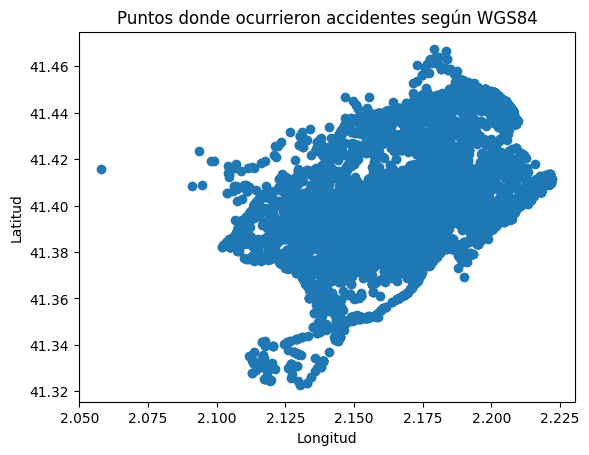

In [9]:
#Gráfico de la ubicación de los puntos georeferenciados en el mapa

plt.scatter(df['Longitud_WGS84'], df['Latitud_WGS84'])
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Puntos donde ocurrieron accidentes según WGS84')
plt.show()

**Resolución: <br>
Los datos geográficos con los que contamos se incluyen unos a otros (calle dentro de barrio, barrio dentro de distrito, etc.). 
Teniendo en cuenta que esta es una primera aproximación al trabajo con estos datos se elegirá el campo que presenta menos granularidad para simplificar en una primera instancia el modelo. 
Entre barrio, distrito, calle, código postal o la geolocalizaión de los accidentes, es distrito el que cumple con nuestras necesidades. 
Son 10 distritos (los valores únicos dicen 11 porque incluye el dato "desconocido"). Por ello, solamente se mantendra el distrito como dato geográfico.
Entre el nombre y el código del districto se elije el segundo porque al ser un número facilita el modelo de aprendizaje, a pesar de que es categórico.
El resto de los datos geográficos no ayudan al presente modelo, por lo ya mencionado, y serán descartados, lo que no significa que no pudieran ser considerados en modelos futuros**

In [10]:
#Borrado de las columnas mencionadas

df= df.drop(['Nom_districte', 'Codi_barri',
        'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal ', 
        'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50',
        'Longitud_WGS84','Latitud_WGS84', 'Longitud', 'Latitud'], 
        axis=1)
df.columns

Index(['Numero_expedient', 'Codi_districte', 'Descripcio_dia_setmana',
       'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes', 'Hora_dia',
       'Descripcio_torn', 'Descripcio_causa_mediata'],
      dtype='object')

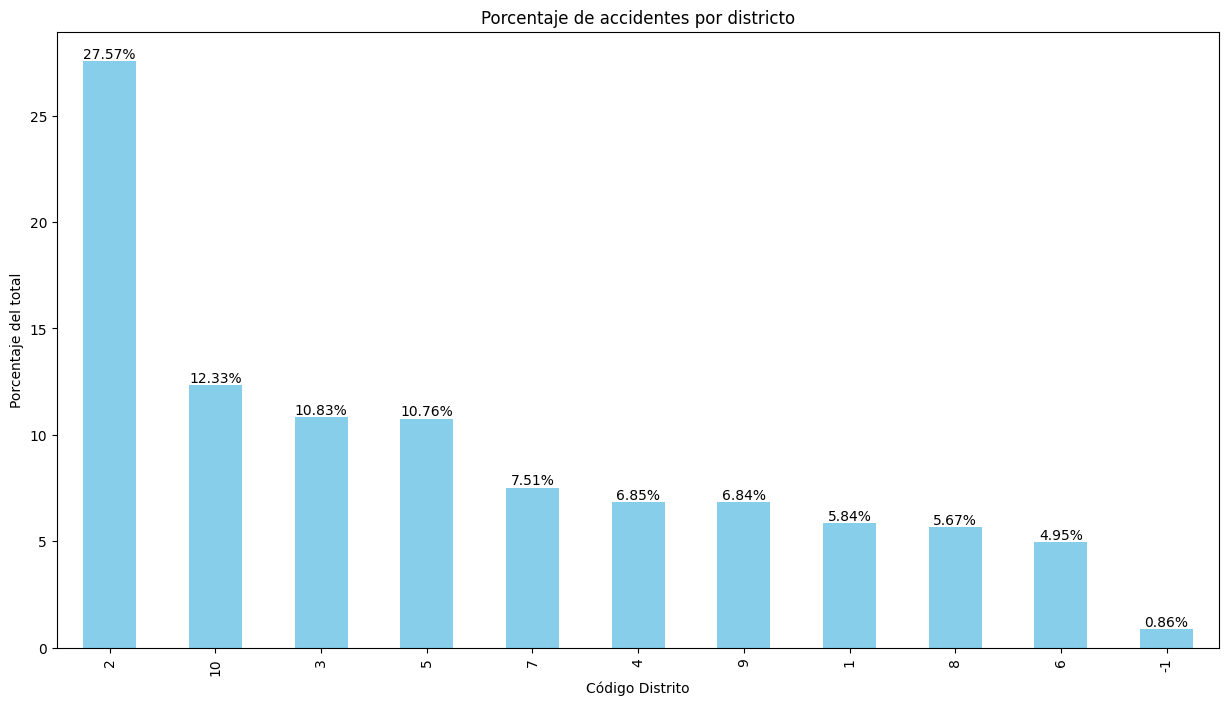

In [11]:
# Obtener los valores únicos y sus conteos por distrito
districto = df['Codi_districte'].value_counts()

# Calcular los porcentajes del total
porcentajes = districto / districto.sum() * 100

# Graficar los porcentajes del total como un gráfico de barras
porcentajes.plot(kind='bar', figsize=(15, 8), color='skyblue')

plt.xlabel('Código Distrito')
plt.ylabel('Porcentaje del total')
plt.title('Porcentaje de accidentes por districto')

# Agregar etiquetas de porcentaje encima de cada barra
for i, porcentaje in enumerate(porcentajes):
    plt.text(i, porcentaje, f'{porcentaje:.2f}%', ha='center', va='bottom')

plt.show()


### Datos temporales

Datos vinculados con el teimpo en el que suceden los accidentes

- Descripción_dia_semana: Nombre del día de la semana
- NK_Any: Año
- Mes_any: Mes del año
- Nom_mes: Nombre del mes
- Dia_mes: Día del mes
- Hora_dia: Hora del día
- Descripcio_torn: Descripción del turno


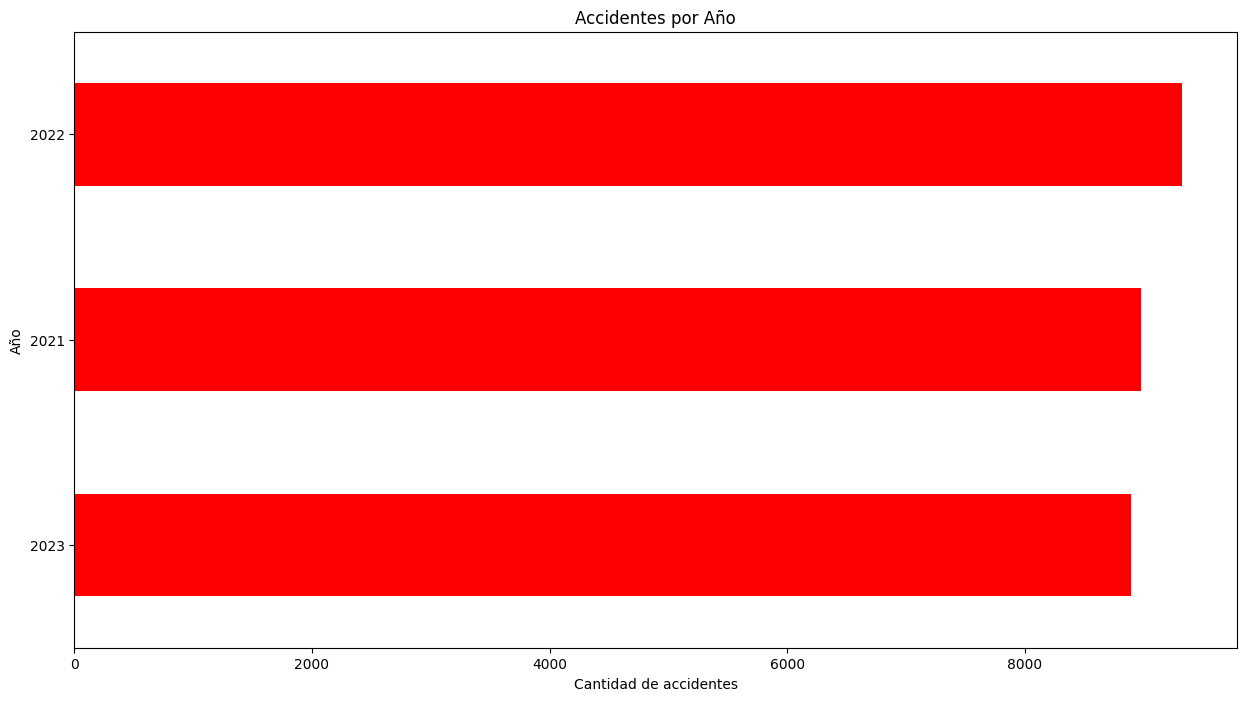

In [12]:
# Obtener los valores únicos y sus conteos
turno = df['NK_Any'].value_counts()

# Ordenar los datos por el recuento de accidentes en orden ascendente
turno = turno.sort_values(ascending=True)

# Graficar el conteo de 'Nombre del districto' como un gráfico de barras
turno.plot(kind='barh', figsize=(15, 8), color='red')

plt.xlabel('Cantidad de accidentes')
plt.ylabel('Año')
plt.title('Accidentes por Año')

plt.show()

In [13]:
#Accidentes por hora
df['Hora_dia'].value_counts().sort_index()

Hora_dia
0      518
1      368
2      220
3      247
4      175
5      265
6      406
7      831
8     1429
9     1474
10    1261
11    1404
12    1645
13    1820
14    2058
15    1824
16    1751
17    1835
18    1838
19    1710
20    1531
21    1165
22     801
23     620
Name: count, dtype: int64

In [14]:
df['Descripcio_torn'].value_counts().sort_index()

Descripcio_torn
Matí     10270
Nit       3214
Tarda    13712
Name: count, dtype: int64

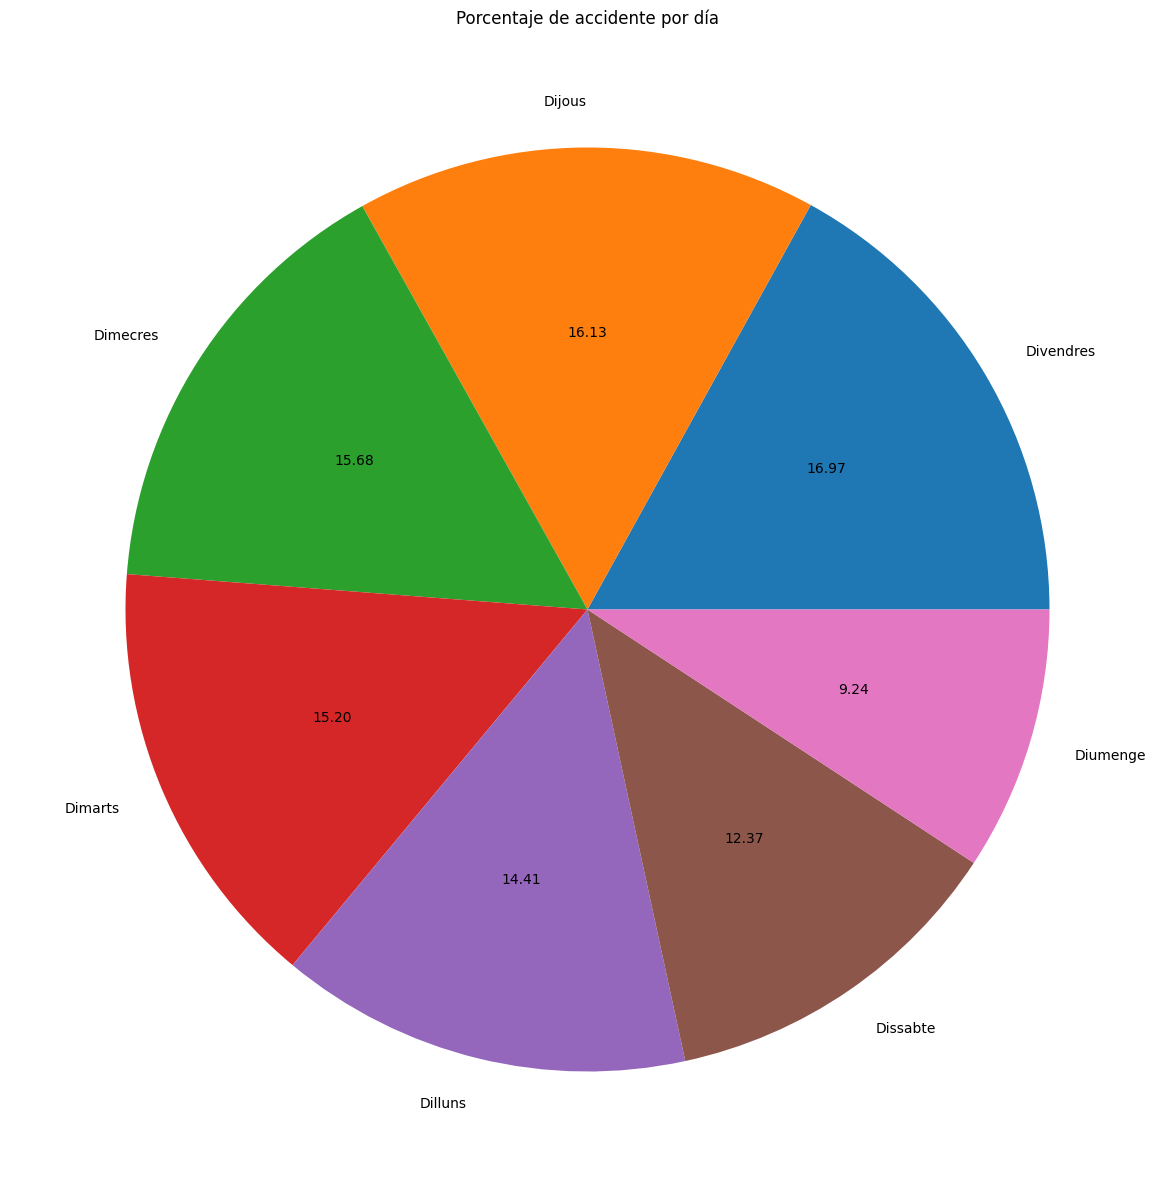

In [15]:
# cuanta de cada causa del accidentes
causas = df['Descripcio_dia_setmana'].value_counts()

# Obtener las etiquetas y colores correspondientes
labels = causas.index
colors = plt.cm.tab10.colors[:len(labels)]

# Graficar el conteo de 'Descripcio_causa_mediata' sin etiquetas
plot = causas.plot(kind='pie', autopct='%.2f', figsize=(15, 15), colors=colors)

plot.set_ylabel('')  # Establecer el eje y en blanco

plt.title('Porcentaje de accidente por día')
plt.show()


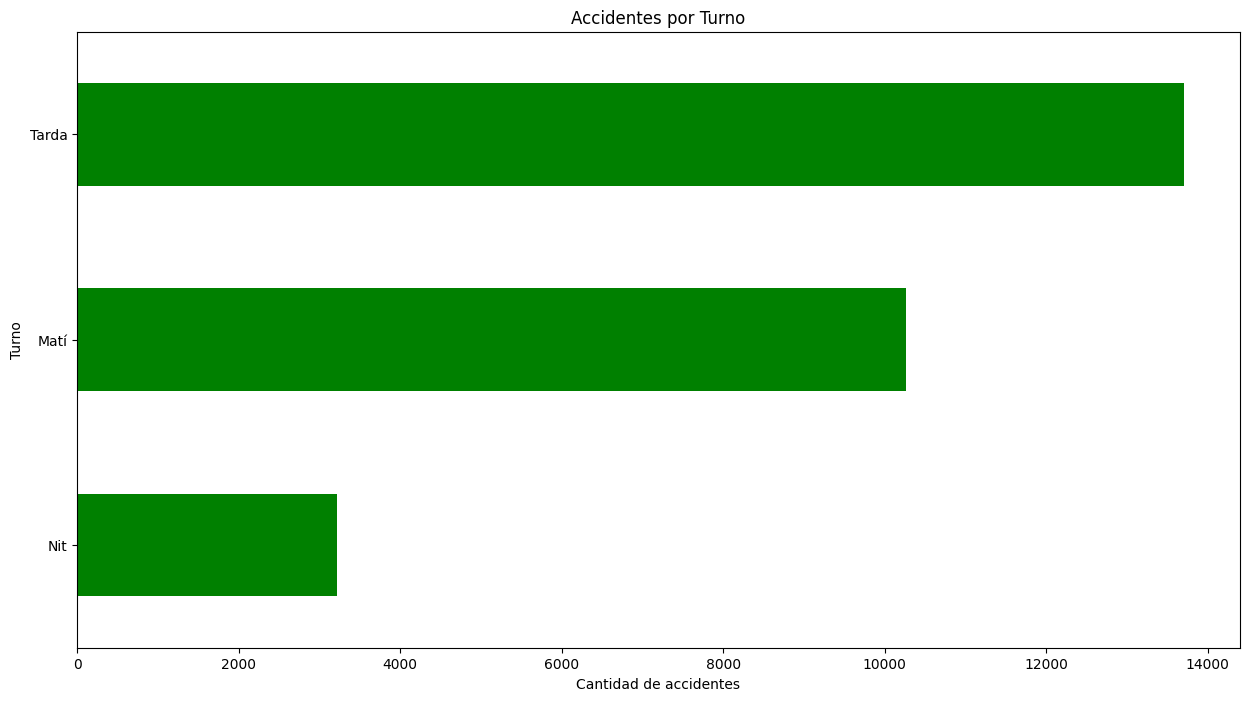

In [16]:
# Obtener los valores únicos y sus conteos
turno = df['Descripcio_torn'].value_counts()

# Ordenar los datos por el recuento de accidentes en orden ascendente
turno = turno.sort_values(ascending=True)

# Graficar el conteo de 'Nombre del districto' como un gráfico de barras
turno.plot(kind='barh', figsize=(15, 8), color='green')

plt.xlabel('Cantidad de accidentes')
plt.ylabel('Turno')
plt.title('Accidentes por Turno')

plt.show()

In [17]:
dfDate = pd.DataFrame()
dfDate['NK_Any'] = df['NK_Any'].astype(int)
dfDate['Mes_any'] = df['Mes_any'].astype(int)
dfDate['Dia_mes'] = df['Dia_mes'].astype(int)

# Creacion de fechas únicas
dfDate['fecha'] = pd.to_datetime(dfDate['NK_Any'].astype(str) + '-' + dfDate['Mes_any'].astype(str) + '-' + dfDate['Dia_mes'].astype(str))

# Contar el número total de accidentes
total_accidentes = len(dfDate)

# Calcular el número total de días en el período
dias_totales = (dfDate['fecha'].max() - dfDate['fecha'].min()).days + 1

# Calcular el promedio de accidentes por día
promedio_accidentes_por_dia = total_accidentes / dias_totales

print(f"El promedio de accidentes por día es: {promedio_accidentes_por_dia:.2f}")

El promedio de accidentes por día es: 24.84


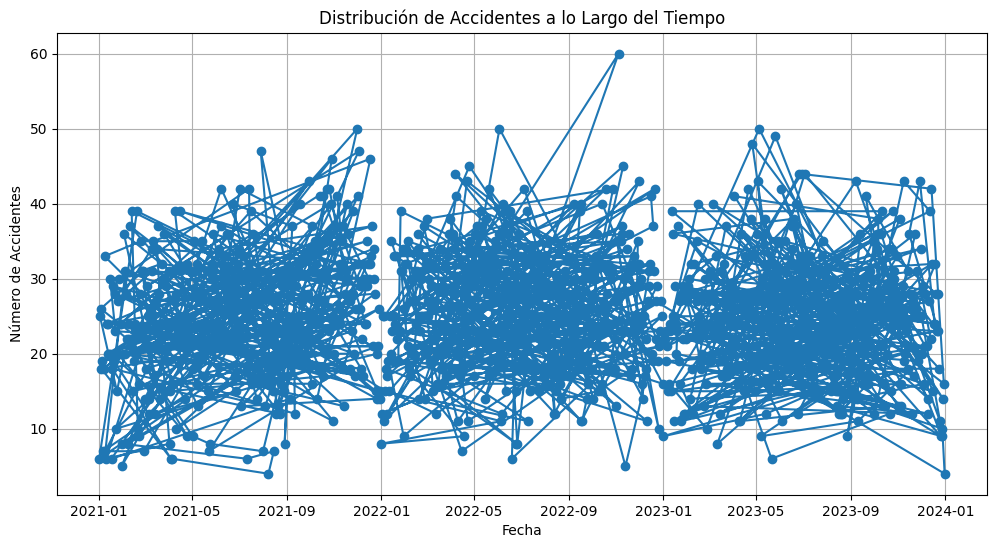

In [18]:
dfDate['fecha'] = pd.to_datetime(dfDate['fecha'])

# Crear una nueva columna que cuente los accidentes por día
dfDate['conteo_accidentes'] = dfDate.groupby('fecha')['fecha'].transform('count')

# Eliminar duplicados para evitar contar múltiples veces el mismo día
df_unique = dfDate.drop_duplicates(subset=['fecha'])

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(df_unique['fecha'], df_unique['conteo_accidentes'], marker='o')
plt.title('Distribución de Accidentes a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Accidentes')
plt.grid(True)
plt.show()


**Resolución: <br>
Entre los campos temporales se ha seleccionado el target de este trabajo que es el turno del día (mañana, tarde o noche)
Al igual que en el caso de los campos espaciales, los campos temporales tienen diferentes granularidad. Para elegir el target se podría haber seleccionado el día del mes o el día de la semana, pero eso resulta demasiado general y dificil de pronosticar. Otra opción sería la hora del día pero resulta ya una granularidad excesiva para nuestro proyecto, por lo que seleccionamos el turno.
Respecto a los campos que se conservan o se descartan como features, se decide eliminar año, hora y día. Año porque la sería cuenta solo con tres años en los que los accvidentes se distribuyen con relativa equidad y no aportar{ia nada al algoritmo predictivo. La hora del día se descarta por estar contenida y agrupada dentro del turno. Finalmente, y con la misma lógica, se elimina día del mes.
Se conservará en cambio el mes (en número que facilita al modelo) y el día de la semana, los que ayudará a anticipar los posibles accidentes dentro de cada turno.**

In [19]:
#Borrado de las columnas mencionadas

df = df.drop(['NK_Any', 'Nom_mes','Dia_mes','Hora_dia'], axis=1)
df.head()

,Numero_expedient,Codi_districte,Descripcio_dia_setmana,Mes_any,Descripcio_torn,Descripcio_causa_mediata
0,2023S000699,-1,Dissabte,2,Tarda,Manca d'atenció a la conducció
1,2023S005197,-1,Divendres,9,Matí,No respectar distàncies
2,2023S007430,-1,Divendres,12,Matí,No respectar distàncies
3,2023S000961,-1,Dissabte,1,Tarda,No respectat pas de vianants
4,2023S006486,-1,Dijous,11,Tarda,Desobeir semàfor


### Otros Datos

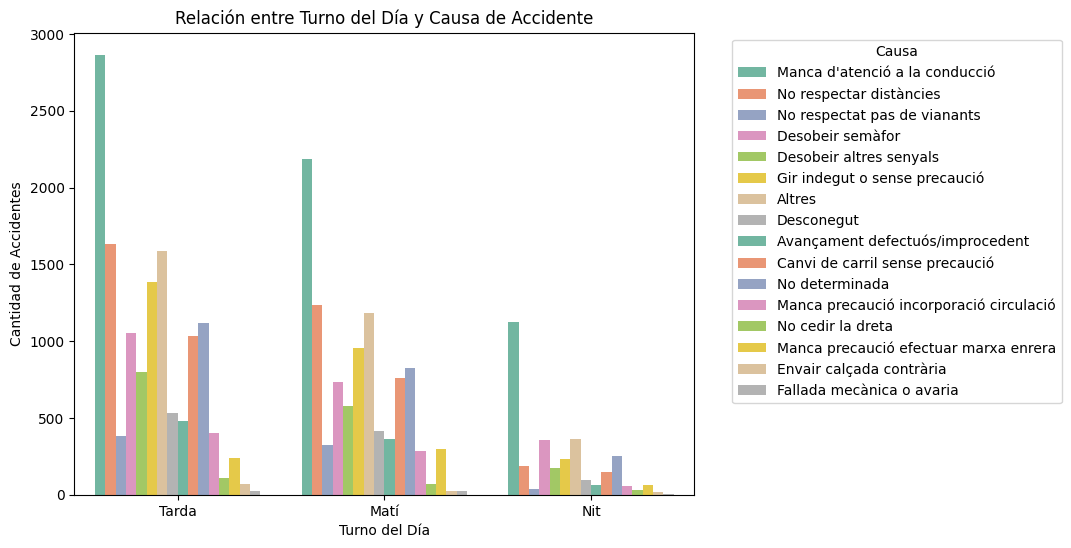

In [20]:
# Crear gráfico de conteo
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Descripcio_torn', hue='Descripcio_causa_mediata', palette='Set2')
plt.title('Relación entre Turno del Día y Causa de Accidente')
plt.xlabel('Turno del Día')
plt.ylabel('Cantidad de Accidentes')
plt.legend(title='Causa', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Resolución:
El número de expediente de cada accidente no contribuye al modelo predictivo por lo que se elimina.
Las causas de cada accidente pueden ser muy útiles para procesos preventivos como factor adicional de análisis. Pero el gráfico anterior muestra que en general se repiten los porcfentajes el patrón de causas en cada turno. Además, el modelo que se propone aquí parte de predecir el momento del día en el que ocurrirá el siniestro, y la causa es algo que se conoce posteriormente por lo que no se podría instroducir en la aplicación real como un feature. Por ello también se elimina.**

In [21]:
#Borrado de las columnas mencionadas

df = df.drop(['Numero_expedient', 'Descripcio_causa_mediata'], axis=1)
df.head()

,Codi_districte,Descripcio_dia_setmana,Mes_any,Descripcio_torn
0,-1,Dissabte,2,Tarda
1,-1,Divendres,9,Matí
2,-1,Divendres,12,Matí
3,-1,Dissabte,1,Tarda
4,-1,Dijous,11,Tarda


## Análisis preliminar de los datos

In [22]:
df.nunique()

Codi_districte            11
Descripcio_dia_setmana     7
Mes_any                   12
Descripcio_torn            3
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27196 entries, 0 to 27195
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Codi_districte          27196 non-null  int64 
 1   Descripcio_dia_setmana  27196 non-null  object
 2   Mes_any                 27196 non-null  int64 
 3   Descripcio_torn         27196 non-null  object
dtypes: int64(2), object(2)
memory usage: 850.0+ KB


In [24]:
# Calcular el recuento de accidentes por mes
mes = df['Mes_any'].value_counts()

# Calcular los porcentajes para cada mes
porcentajes = mes / mes.sum() * 100

# Crear un DataFrame con los porcentajes y sus correspondientes nombres de mes
mes = pd.DataFrame({'Mes': porcentajes.index, 'Porcentaje': porcentajes.values})

# Formatear los porcentajes con dos decimales y el símbolo %
mes['Porcentaje'] = mes['Porcentaje'].apply(lambda x: '{:.2f}%'.format(x))

print(mes.rename_axis('Porcentaje de accidentes por mes').to_string(index=False))


 Mes Porcentaje
  10      9.39%
   6      9.18%
  11      9.14%
   5      9.01%
   7      8.96%
  12      8.48%
   3      8.29%
   4      8.07%
   9      8.04%
   2      7.62%
   1      7.20%
   8      6.63%


### Tratamiento de nulos

In [25]:
# Calcular el total de filas en el campo 'Nom_Districte'
total_filas = df['Codi_districte'].count()

# Contar el número de veces que aparece 'Desconegut' en 'Nom_Districte'
num_desconegut = df[df['Codi_districte'] == -1]['Codi_districte'].count()

# Calcular el porcentaje
porcentaje_desconegut = (num_desconegut / total_filas) * 100

print(f"El porcentaje de 'Desconegut' en 'Nom_Districte' es: {porcentaje_desconegut:.2f}%")

El porcentaje de 'Desconegut' en 'Nom_Districte' es: 0.86%


**Resolución: <br>
Siendo tan bajo el porcentaje de distritos desconocidos (0.86%) y puediendo estos afectar a la eficiencia del modelo se borran**

In [26]:
#Borrar los accidentes donde no se conoce el districto
df = df[df['Codi_districte'] != -1]

df.head()

,Codi_districte,Descripcio_dia_setmana,Mes_any,Descripcio_torn
13,10,Dimarts,8,Nit
14,10,Dimarts,6,Tarda
15,10,Dimecres,6,Tarda
16,10,Dimarts,9,Matí
17,10,Dilluns,5,Matí


# Aplicación del modelo predictivo


## Preparación de los datos

A partir de los datos, se crean columnas que sean numéricas para procesarlas.

In [27]:
# Definir un diccionario que mapee cada día de la semana a su número correspondiente, comenzando desde el domingo
dias_dict = {
    'Diumenge': 1,
    'Dilluns': 2,
    'Dimarts': 3,
    'Dimecres': 4,
    'Dijous': 5,
    'Divendres': 6,
    'Dissabte': 7
}

# Crear una nueva columna 'Dia_Numero' asignando el número correspondiente a cada día de la semana
df['Dia_Numero'] = df['Descripcio_dia_setmana'].map(dias_dict)

# Definir un diccionario que mapee cada turno del día a su número correspondiente
turno_dict = {
    'Matí': 0,
    'Tarda': 1,
    'Nit': 2,
}

# Crear una nueva columna 'Turno_Numero' asignando el número correspondiente a cada turno del día
df['Turno_Numero'] = df['Descripcio_torn'].map(turno_dict)


df.head()

,Codi_districte,Descripcio_dia_setmana,Mes_any,Descripcio_torn,Dia_Numero,Turno_Numero
13,10,Dimarts,8,Nit,3,2
14,10,Dimarts,6,Tarda,3,1
15,10,Dimecres,6,Tarda,4,1
16,10,Dimarts,9,Matí,3,0
17,10,Dilluns,5,Matí,2,0


Se crea un nuevo Data Frame solo con los campos numéricos, sobre el cual se aplicará el modelo

In [28]:
colum_num = ['Turno_Numero','Codi_districte', 'Mes_any', 'Dia_Numero']
dfTran = df[colum_num].copy()

dfTran.head()

,Turno_Numero,Codi_districte,Mes_any,Dia_Numero
13,2,10,8,3
14,1,10,6,3
15,1,10,6,4
16,0,10,9,3
17,0,10,5,2


## Preprocesado

In [29]:
dfTran = dfTran.astype('int64')
dfTran.dtypes

Turno_Numero      int64
Codi_districte    int64
Mes_any           int64
Dia_Numero        int64
dtype: object

In [30]:
# Convertir columnas a tipo 'category'
dfTran['Turno_Numero'] = dfTran['Turno_Numero'].astype('category')
dfTran['Codi_districte'] = dfTran['Codi_districte'].astype('category')
dfTran['Mes_any'] = dfTran['Mes_any'].astype('category')
dfTran['Dia_Numero'] = dfTran['Dia_Numero'].astype('category')

# Comprobar los tipos de datos
print(dfTran.dtypes)

Turno_Numero      category
Codi_districte    category
Mes_any           category
Dia_Numero        category
dtype: object


In [31]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(dfTran['Codi_districte'], dfTran['Turno_Numero'], margins=True)

print(contingency_table)

Turno_Numero        0      1     2    All
Codi_districte                           
1                 502    792   293   1587
2                2837   3793   867   7497
3                1064   1483   399   2946
4                 738    951   173   1862
5                1147   1473   306   2926
6                 533    683   131   1347
7                 790   1019   234   2043
8                 544    797   200   1541
9                 721    923   217   1861
10               1306   1676   370   3352
All             10182  13590  3190  26962


In [32]:
# Aplicar el test de Chi-Cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Estadística Chi2: {chi2}, p-valor: {p}")

Estadística Chi2: 118.78864208544255, p-valor: 1.6268651934758522e-12


Habiendo un p-valor bajo puede inferirse qur existe una relación estadísticamente significativa entre el distrito y el turno del día en el que ocurren los accidentes. Esto sugiere que ciertos distritos podrían tener más accidentes en ciertos turnos que en otros, lo que podría ser relevante para la prevención y gestión de accidentes.

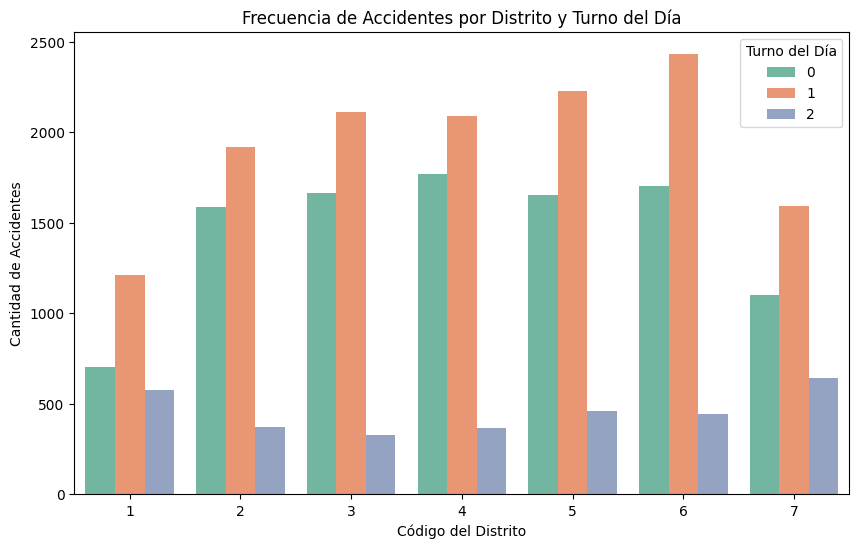

In [33]:
# Contar las frecuencias
counts = dfTran.groupby(['Dia_Numero', 'Turno_Numero']).size().reset_index(name='count')

# Crear gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='Dia_Numero', y='count', hue='Turno_Numero', palette='Set2')
plt.title('Frecuencia de Accidentes por Distrito y Turno del Día')
plt.xlabel('Código del Distrito')
plt.ylabel('Cantidad de Accidentes')
plt.legend(title='Turno del Día', loc='upper right')
plt.show()


Se nota que se repiten las proporciones de accidente por turno en cada día de la semana, pero que aumentan o disminuyen proporcionalmente dependiendo el día

In [34]:
# Crear una lista de los datos del turno agrupados por mes
grouped_turno_mes = [dfTran[dfTran['Mes_any'] == mes]['Turno_Numero'] for mes in dfTran['Mes_any'].unique()]

# Realizar la prueba Kruskal-Wallis
stat, p_value = kruskal(*grouped_turno_mes)

print(f"Estadística Kruskal-Wallis: {stat}, p-valor: {p_value}")

Estadística Kruskal-Wallis: 142.07224602062377, p-valor: 6.168756713899884e-25


Un p-valor tan pequeño indica que hay diferencias estadísticamente significativas entre la distribución de los turnos del día según los meses. 

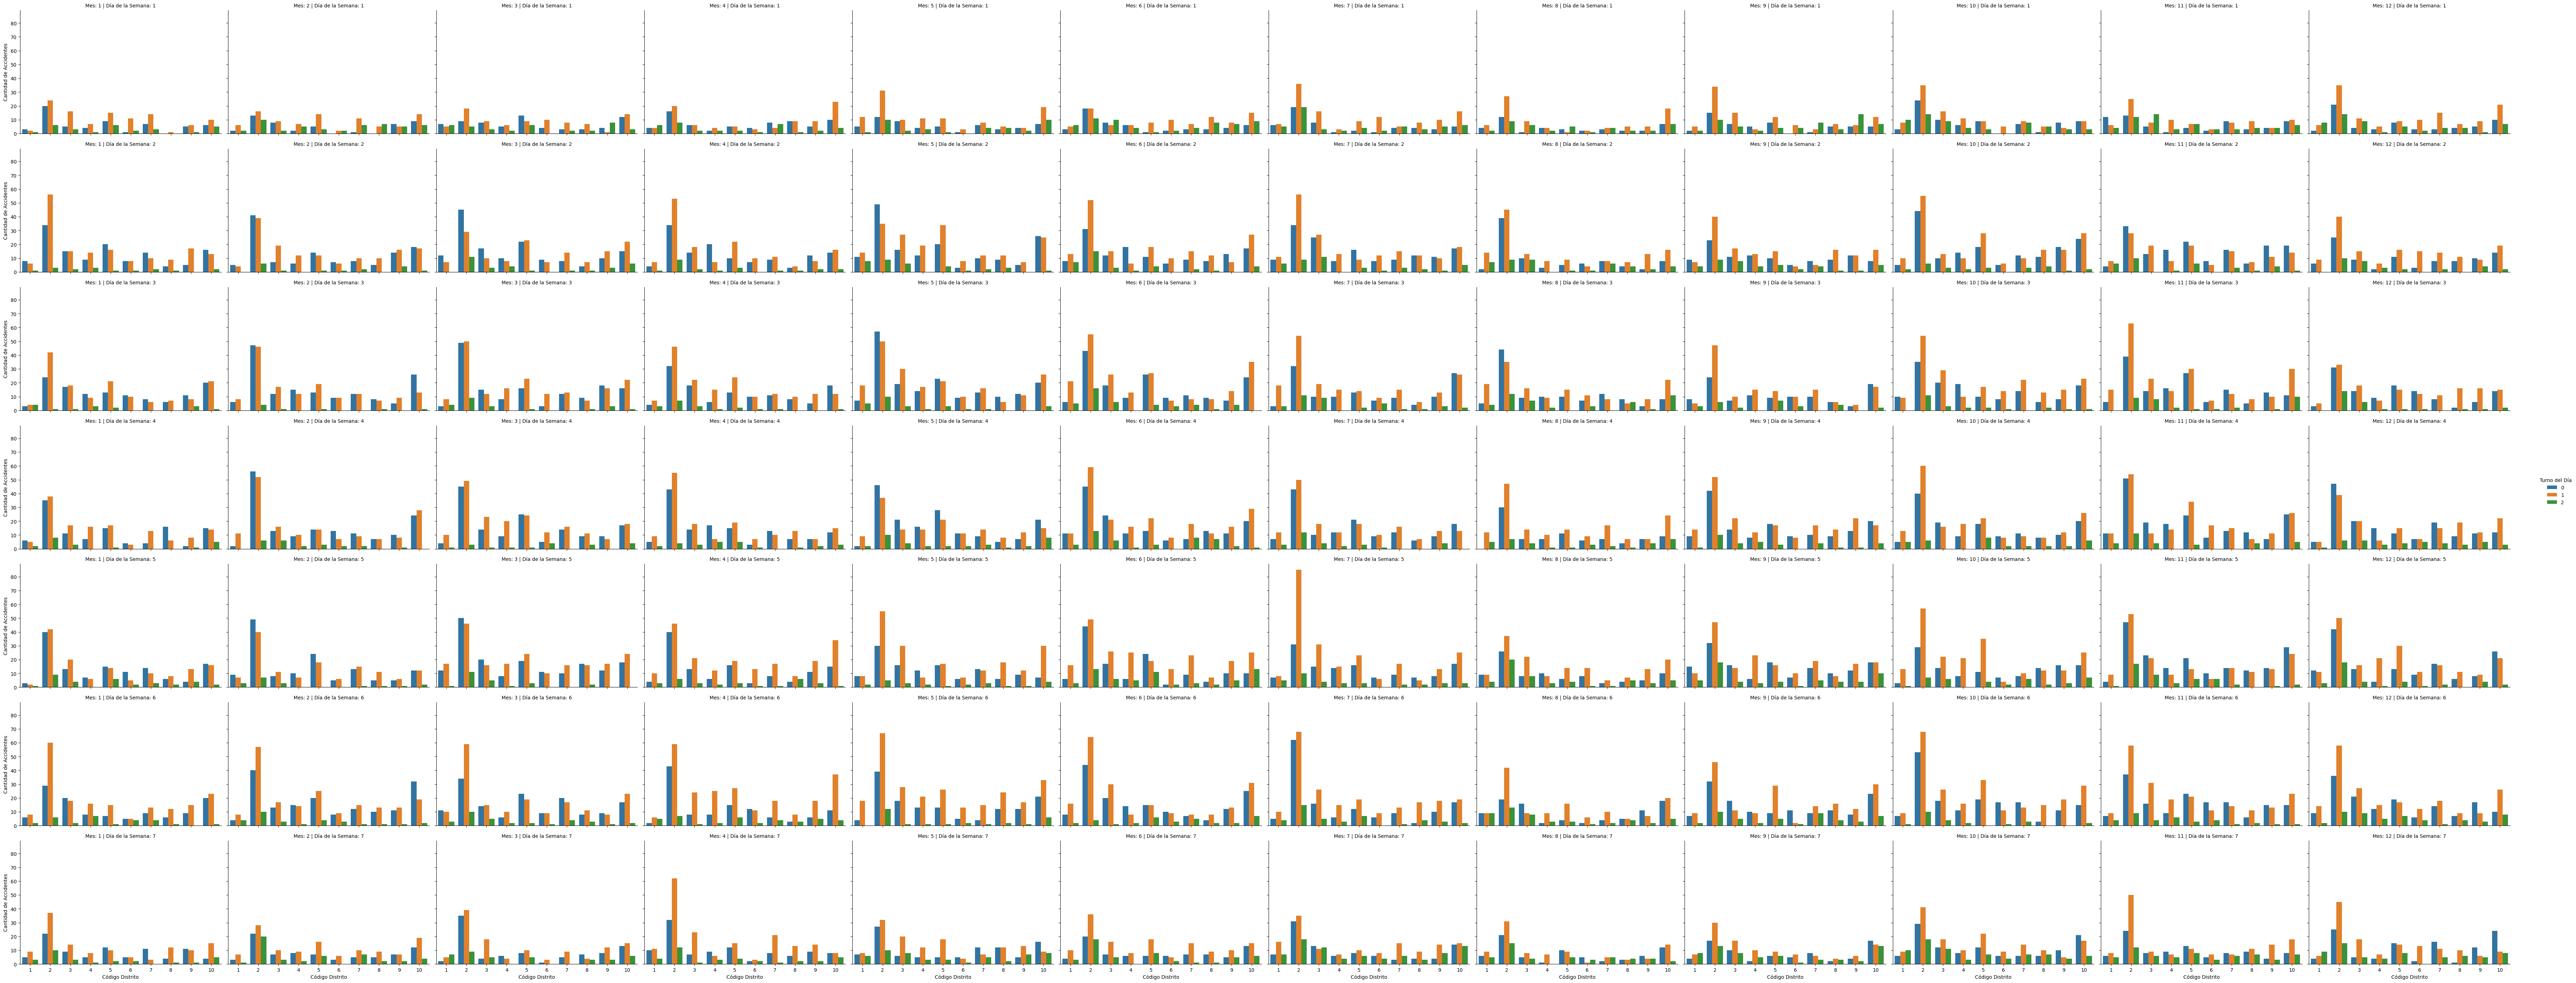

In [35]:
# Crear un gráfico de barras apiladas que combine distrito, día de la semana, turno y mes
g = sns.catplot(
    data=dfTran, kind='count', x='Codi_districte', hue='Turno_Numero', 
    col='Mes_any', row='Dia_Numero', 
    height=4, aspect=1.5
)

g.set_titles("Mes: {col_name} | Día de la Semana: {row_name}")
g.set_axis_labels("Código Distrito", "Cantidad de Accidentes")
g._legend.set_title("Turno del Día")

plt.show()

Transformación de los datos con OneHotEncoder (todos menos el target, naturalmente)

In [36]:
# Inicializa el encoder
encoder = OneHotEncoder()

# Aplica el encoder a las columnas categóricas y convierte a array
X_encoded = encoder.fit_transform(dfTran[['Codi_districte', 'Dia_Numero', 'Mes_any']]).toarray()

# Crear un DataFrame con las columnas codificadas
encoded_columns = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['Codi_districte', 'Dia_Numero', 'Mes_any']))

# Concatenar el DataFrame original con las nuevas columnas codificadas
dfTran = pd.concat([dfTran.reset_index(drop=True), encoded_columns.reset_index(drop=True)], axis=1)

# Eliminar las columnas originales si no las necesitas
dfTran.drop(['Codi_districte', 'Dia_Numero', 'Mes_any'], axis=1, inplace=True)

# Mostrar el DataFrame actualizado
dfTran.head()

,Turno_Numero,Codi_districte_1,Codi_districte_2,Codi_districte_3,Codi_districte_4,Codi_districte_5,Codi_districte_6,Codi_districte_7,Codi_districte_8,Codi_districte_9,...,Mes_any_3,Mes_any_4,Mes_any_5,Mes_any_6,Mes_any_7,Mes_any_8,Mes_any_9,Mes_any_10,Mes_any_11,Mes_any_12
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelo predictivo de clasificación

## División de Test y Train

In [37]:
X = dfTran.drop(['Turno_Numero'],axis=1)
y = dfTran[['Turno_Numero']]

y.head()

,Turno_Numero
0,2
1,1
2,1
3,0
4,0


In [38]:
X.head()

,Codi_districte_1,Codi_districte_2,Codi_districte_3,Codi_districte_4,Codi_districte_5,Codi_districte_6,Codi_districte_7,Codi_districte_8,Codi_districte_9,Codi_districte_10,...,Mes_any_3,Mes_any_4,Mes_any_5,Mes_any_6,Mes_any_7,Mes_any_8,Mes_any_9,Mes_any_10,Mes_any_11,Mes_any_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18873, 29) (8089, 29) (18873, 1) (8089, 1)


In [40]:
dfTran['Turno_Numero'].value_counts()

Turno_Numero
1    13590
0    10182
2     3190
Name: count, dtype: int64

## Aplicación de modelos

In [41]:
KNN = KNeighborsClassifier()

In [42]:
LR = LogisticRegression(solver = 'lbfgs', random_state=42)

In [43]:
svc_model = SVC(kernel='linear')

In [44]:
RF = RandomForestClassifier(random_state=42)

Entrenamiento de los modelos

In [45]:
KNN.fit(X_train, y_train)
LR.fit(X_train, y_train)
svc_model.fit(X_train, y_train)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Predicción

In [46]:
y_pred_KNN = KNN.predict(X_test)
y_pred_LR = LR.predict(X_test)
y_pred_SVC = svc_model.predict(X_test)
y_pred_RF = RF.predict(X_test)

## Resultados

In [47]:
#Accuracy
acc_KNN = KNN.score(X_test, y_test)
acc_LR = LR.score(X_test, y_test)
acc_SVC = svc_model.score(X_test, y_test)
acc_RF = RF.score(X_test, y_test)


acc_KNN = "{:.2f}".format(acc_KNN)
acc_LR = "{:.2f}".format(acc_LR)
acc_SVC = "{:.2f}".format(acc_SVC)
acc_RF = "{:.2f}".format(acc_RF)


#F1
f1_KNN = f1_score(y_test, y_pred_KNN, average='macro')
f1_LR = f1_score(y_test, y_pred_LR, average='macro')
f1_SVC = f1_score(y_test, y_pred_SVC, average='macro')
f1_RF = f1_score(y_test, y_pred_RF, average='macro')


f1_KNN = "{:.2f}".format(f1_KNN)
f1_LR = "{:.2f}".format(f1_LR)
f1_SVC = "{:.2f}".format(f1_SVC)
f1_RF = "{:.2f}".format(f1_RF)

#recall
recall_KNN = recall_score(y_test, y_pred_KNN, average='macro')
recall_LR = recall_score(y_test, y_pred_LR, average='macro')
recall_SVC = recall_score(y_test, y_pred_SVC, average='macro')
recall_RF = recall_score(y_test, y_pred_RF, average='macro')


recall_KNN = "{:.2f}".format(recall_KNN)
recall_LR = "{:.2f}".format(recall_LR)
recall_SVC = "{:.2f}".format(recall_SVC)
recall_RF = "{:.2f}".format(recall_RF)
#cuadro de resultados
resultados = pd.DataFrame( data = [['KNN', acc_KNN, f1_KNN, recall_KNN],
                                [ 'LR', acc_LR, f1_LR, recall_LR],
                                ['SVC', acc_SVC,f1_SVC, recall_SVC],
                                ['RF', acc_RF, f1_RF, recall_RF]],
                       columns = ['Modelo', 'Accuracy', 'F1', 'Recall'])


resultados

,Modelo,Accuracy,F1,Recall
0,KNN,0.47,0.34,0.35
1,LR,0.51,0.25,0.34
2,SVC,0.51,0.23,0.33
3,RF,0.48,0.33,0.34


Matatrices de confusión de cada modelo

Text(0.5, 427.9555555555555, 'Predicción')

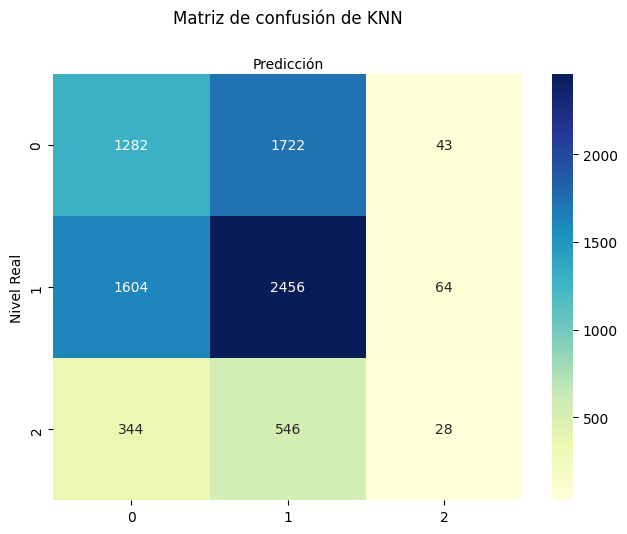

In [48]:
KNN_matrix = metrics.confusion_matrix(y_test, y_pred_KNN)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(KNN_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión de KNN', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

Text(0.5, 427.9555555555555, 'Predicción')

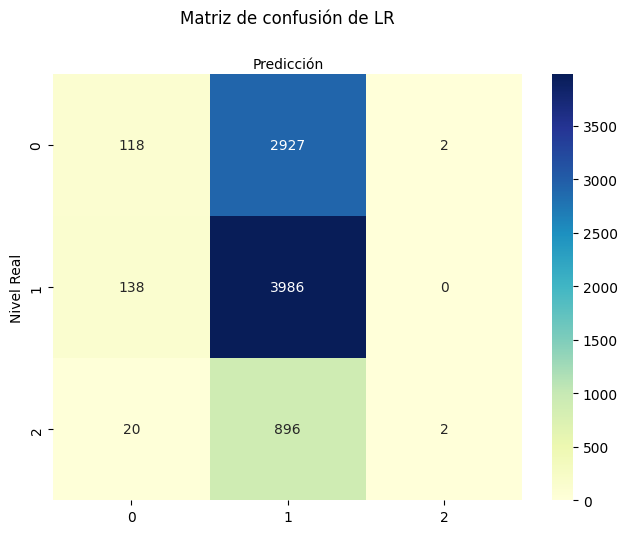

In [49]:
LR_matrix = metrics.confusion_matrix(y_test, y_pred_LR)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(LR_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión de LR', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

Text(0.5, 427.9555555555555, 'Predicción')

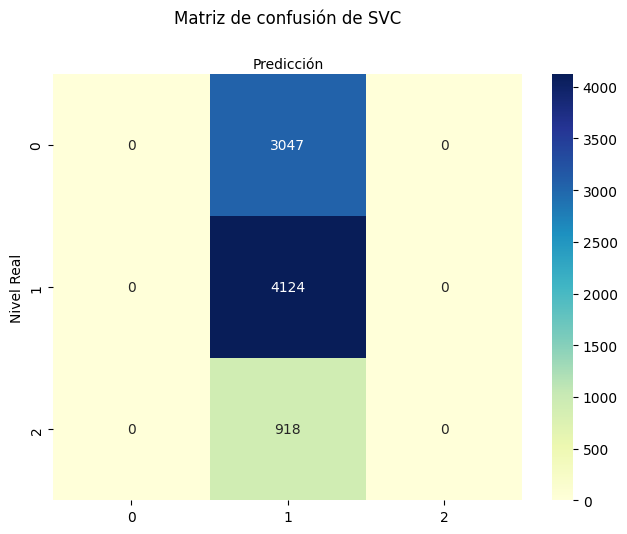

In [50]:
SVC_matrix = metrics.confusion_matrix(y_test, y_pred_SVC)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(SVC_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión de SVC', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

Text(0.5, 427.9555555555555, 'Predicción')

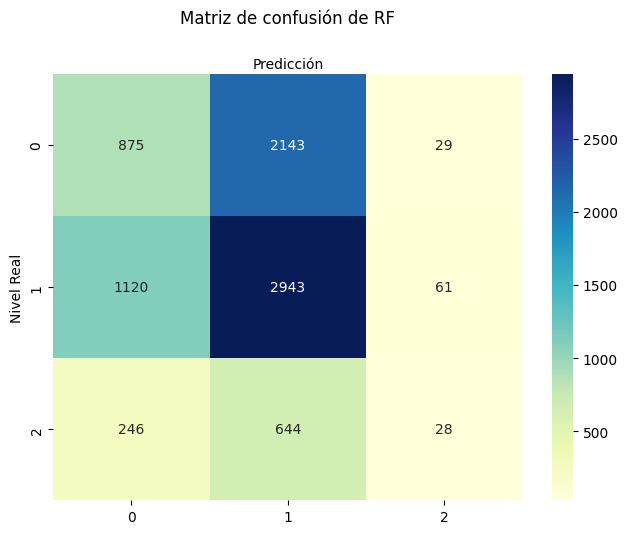

In [51]:
RF_matrix = metrics.confusion_matrix(y_test, y_pred_RF)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(RF_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión de RF', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

Cross Validation

In [52]:
# Reinicializar modelos
KNN = KNeighborsClassifier()
LR = LogisticRegression(solver='lbfgs', random_state=42)
sv_classifier  = SVC(kernel='linear')  
RF = RandomForestClassifier(random_state=42)

# Realizar validación cruzada para cada modelo
cv_KNN = cross_val_score(KNN, X, y, cv=5, scoring='f1_macro')
cv_LR = cross_val_score(LR, X, y, cv=5, scoring='f1_macro')
cv_SVC = cross_val_score(sv_classifier, X, y, cv=5, scoring='f1_macro') 
cv_RF = cross_val_score(RF, X, y, cv=5, scoring='f1_macro')

# Calcular la media de las puntuaciones de validación cruzada
cv_KNN = "{:.2f}".format(cv_KNN.mean())
cv_LR = "{:.2f}".format(cv_LR.mean())
cv_SVC = "{:.2f}".format(cv_SVC.mean())
cv_RF = "{:.2f}".format(cv_RF.mean())

cv = [cv_KNN, cv_LR, cv_SVC, cv_RF]
resultados['Cross Validation'] = cv

resultados


,Modelo,Accuracy,F1,Recall,Cross Validation
0,KNN,0.47,0.34,0.35,0.34
1,LR,0.51,0.25,0.34,0.24
2,SVC,0.51,0.23,0.33,0.22
3,RF,0.48,0.33,0.34,0.33


Se seleccionan los modelos de RF y KNN que, si bien tienen una accuracy un poco menor muestran en la matriz de confusión una distribución más correcta de las muestras

## Mejora de parámetros

In [53]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf,
                                param_distributions = random_grid,
                                n_iter = 100, 
                                cv = 5, 
                                scoring='neg_mean_absolute_error', 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)


rf_random.fit(X,y.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [54]:
RF_BP = RandomForestClassifier(random_state=42, n_estimators = 822, min_samples_split = 5, min_samples_leaf = 4, 
                               max_features ='sqrt', max_depth = 10, bootstrap = True)
RF_BP.fit(X_train, y_train)
y_pred_RF_BP = RF_BP.predict(X_test)

In [55]:
# Calcular las métricas en el conjunto de test
acc_RF_BP = RF_BP.score(X_test, y_test)
acc_RF_BP = "{:.2f}".format(acc_RF_BP)

# Predicción en el conjunto de test
y_pred_RF_BP = RF_BP.predict(X_test)

# Calcular F1 Score y Recall
f1_RF_BP = f1_score(y_test, y_pred_RF_BP, average='macro')
f1_RF_BP = "{:.2f}".format(f1_RF_BP)

recall_RF_BP = recall_score(y_test, y_pred_RF_BP, average='macro')
recall_RF_BP = "{:.2f}".format(recall_RF_BP)

# Reinicializar el modelo para evitar overfitting
RF_BP = RandomForestClassifier(random_state=42, 
                               n_estimators=822, 
                               min_samples_split=5, 
                               min_samples_leaf=4, 
                               max_features='sqrt', 
                               max_depth=10, 
                               bootstrap=True)

# Realizar validación cruzada
cv_RF_BP = cross_val_score(RF_BP, X, y, cv=5, scoring='f1_macro')
cv_RF_BP = "{:.2f}".format(cv_RF_BP.mean())

# Imprimir los resultados
print(f"Accuracy: {acc_RF_BP}")
print(f"F1 Score: {f1_RF_BP}")
print(f"Recall: {recall_RF_BP}")
print(f"Cross-validated F1 Score: {cv_RF_BP}")


Accuracy: 0.51
F1 Score: 0.25
Recall: 0.33
Cross-validated F1 Score: 0.24


Matriz de Confusión con mejores parámetros

Text(0.5, 427.9555555555555, 'Predicción')

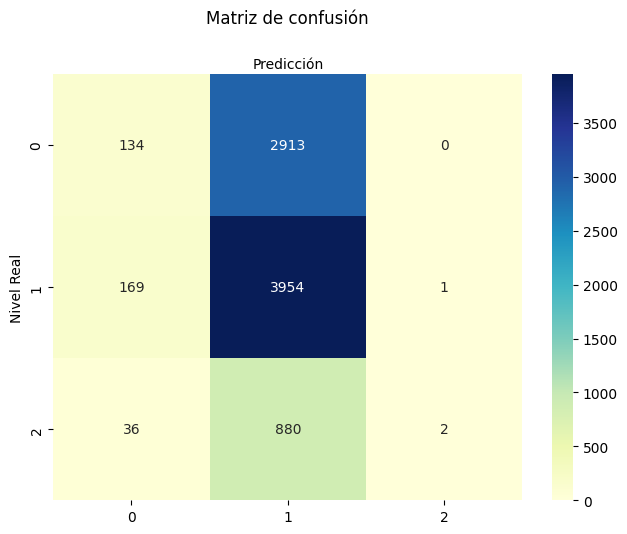

In [56]:
RF_BP_matrix = metrics.confusion_matrix(y_test, y_pred_RF_BP)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(RF_BP_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

In [57]:
f1s = []

# Calculating f1 score for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # using average='weighted' to calculate a weighted average for the 4 classes 
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

Text(0, 0.5, 'F1 Score')

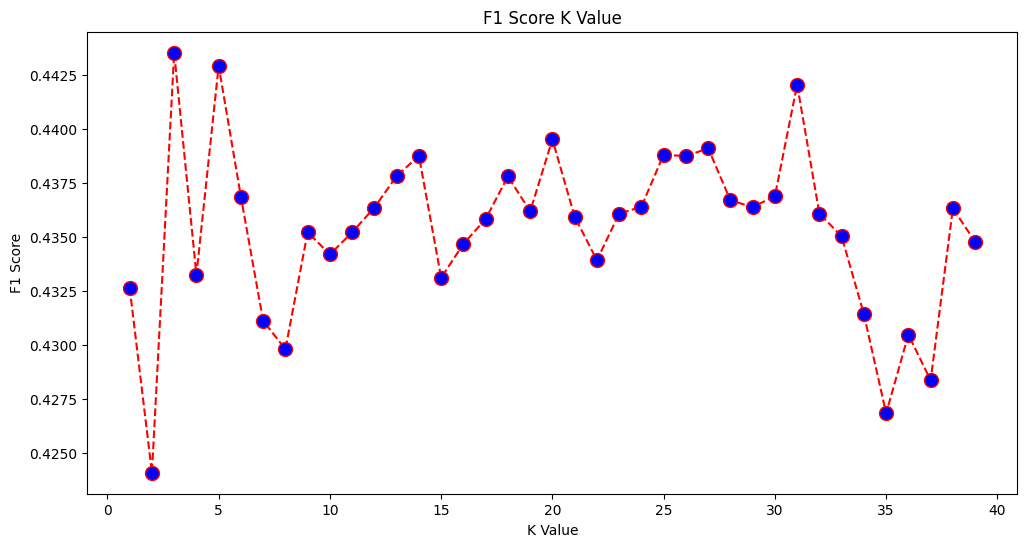

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1s, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

In [59]:
KNN_BP = KNeighborsClassifier(n_neighbors=3)
KNN_BP.fit(X_train, y_train)
y_pred_KNN_BP = KNN_BP.predict(X_test)

In [60]:
acc_KNN_BP = KNN_BP.score(X_test, y_test)
acc_KNN_BP = "{:.2f}".format(acc_KNN_BP)

acc_KNN_BP = KNN_BP.score(X_test, y_test)
acc_KNN_BP = "{:.2f}".format(acc_KNN_BP)

f1_KNN_BP = f1_score(y_test, y_pred_KNN_BP, average='macro')
f1_KNN_BP = "{:.2f}".format(f1_KNN_BP)

recall_KNN_BP = recall_score(y_test, y_pred_KNN_BP, average='macro')
recall_KNN_BP = "{:.2f}".format(recall_KNN_BP)

#se reinicializa el modelo para evitar over fitting
KNN_BP = KNeighborsClassifier(n_neighbors=14)
cv_KNN_BP = cross_val_score(KNN_BP, X, y, cv=5, scoring='f1_macro')
cv_KNN_BP = "{:.2f}".format(cv_KNN_BP.mean())

Text(0.5, 427.9555555555555, 'Predicción')

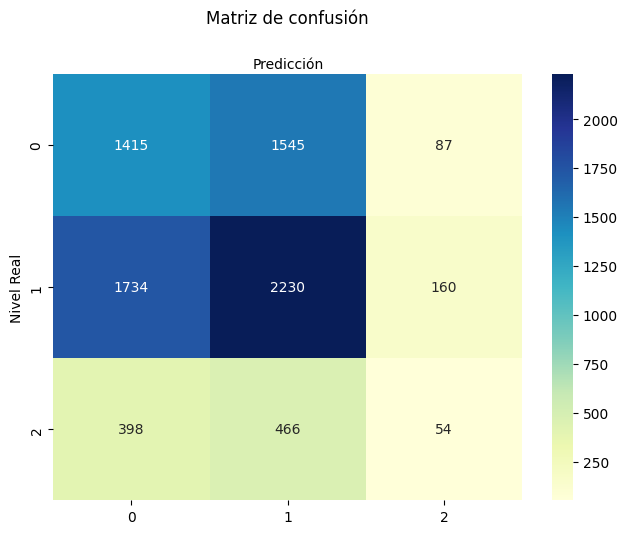

In [61]:
KNN_BP_matrix = metrics.confusion_matrix(y_test, y_pred_KNN_BP)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(KNN_BP_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Nivel Real')
plt.xlabel('Predicción')

In [62]:
resultados.loc[4]= ['RF Best Parameter', acc_RF_BP, f1_RF_BP, recall_RF_BP, cv_RF_BP]
resultados.loc[5]= ['KNN Best Parameter', acc_KNN_BP, f1_KNN_BP, recall_KNN_BP, cv_KNN_BP]

resultados

,Modelo,Accuracy,F1,Recall,Cross Validation
0,KNN,0.47,0.34,0.35,0.34
1,LR,0.51,0.25,0.34,0.24
2,SVC,0.51,0.23,0.33,0.22
3,RF,0.48,0.33,0.34,0.33
4,RF Best Parameter,0.51,0.25,0.33,0.24
5,KNN Best Parameter,0.46,0.35,0.35,0.33


La mejora de parámetros del modelo KNN da una pequeña mejora

In [63]:
y.value_counts()

Turno_Numero
1               13590
0               10182
2                3190
Name: count, dtype: int64

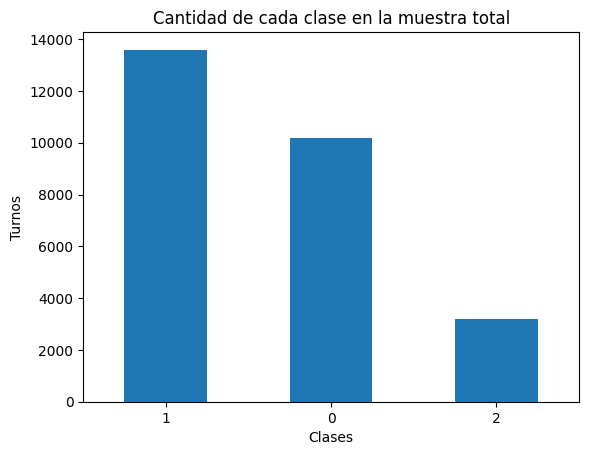

In [64]:
count_classes = pd.value_counts(y['Turno_Numero'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Cantidad de cada clase en la muestra total")
plt.xlabel("Clases")
plt.ylabel("Turnos");

In [65]:
y_train.value_counts()

Turno_Numero
1               9466
0               7135
2               2272
Name: count, dtype: int64

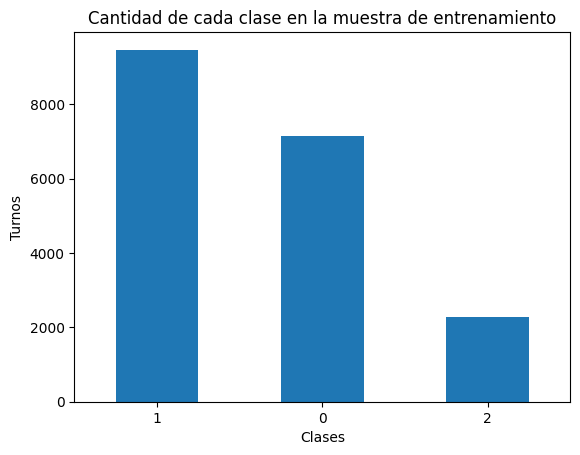

In [66]:
count_classes = pd.value_counts(y_train['Turno_Numero'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Cantidad de cada clase en la muestra de entrenamiento")
plt.xlabel("Clases")
plt.ylabel("Turnos");

In [67]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='auto')
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_over['Turno_Numero'].value_counts()

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
count_classes = pd.value_counts(y_over['Turno_Numero'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Cantidad de cada clase en la muestra balanceada")
plt.xlabel("Clases")
plt.ylabel("Turnos");

In [ ]:
RF_BAL = RandomForestClassifier(random_state=42, n_estimators = 911, min_samples_split = 2, min_samples_leaf = 2, 
                               max_features = 'auto', max_depth = None, bootstrap = True)
RF_BAL.fit(X_over, y_over)
y_pred_RF_BAL = RF_BAL.predict(X_test)

In [ ]:
acc_RF_BAL = RF_BAL.score(X_test, y_test)
acc_RF_BAL = "{:.2f}".format(acc_RF_BAL)

f1_RF_BAL = f1_score(y_test, y_pred_RF_BAL, average='macro')
f1_RF_BAL = "{:.2f}".format(f1_RF_BAL)

recall_RF_BAL = recall_score(y_test, y_pred_RF_BAL, average='macro')
recall_RF_BAL = "{:.2f}".format(recall_RF_BAL)

#se reinicializa el modelo para evitar over fitting
RF_BAL = RandomForestClassifier(random_state=42, n_estimators = 911, min_samples_split = 2, min_samples_leaf = 2, 
                               max_features = 'auto', max_depth = None, bootstrap = True)
cv_RF_BAL = cross_val_score(RF_BAL, X, y, cv=5, scoring='f1_macro')
cv_RF_BAL = "{:.2f}".format(cv_RF_BAL.mean())

In [ ]:
KNN_BAL = KNeighborsClassifier(n_neighbors=14)
KNN_BAL.fit(X_over, y_over)
y_pred_KNN_BAL = KNN_BAL.predict(X_test)

In [ ]:
acc_KNN_BAL = KNN_BAL.score(X_test, y_test)
acc_KNN_BAL = "{:.2f}".format(acc_KNN_BAL)

acc_KNN_BAL = KNN_BAL.score(X_test, y_test)
acc_KNN_BAL = "{:.2f}".format(acc_KNN_BAL)

f1_KNN_BAL = f1_score(y_test, y_pred_KNN_BAL, average='macro')
f1_KNN_BAL = "{:.2f}".format(f1_KNN_BAL)

recall_KNN_BAL = recall_score(y_test, y_pred_KNN_BAL, average='macro')
recall_KNN_BAL = "{:.2f}".format(recall_KNN_BAL)

#se reinicializa el modelo para evitar over fitting
KNN_BAL = KNeighborsClassifier(n_neighbors=14)
cv_KNN_BAL = cross_val_score(KNN_BAL, X, y, cv=5, scoring='f1_macro')
cv_KNN_BAL = "{:.2f}".format(cv_KNN_BAL.mean())

In [ ]:
resultados.loc[6]= ['RF Balanced', acc_RF_BAL, f1_RF_BAL, recall_RF_BAL, cv_RF_BAL]
resultados.loc[7]= ['KNN Balanced', acc_KNN_BAL, f1_KNN_BAL, recall_KNN_BAL, cv_KNN_BAL]

resultados

Balacear las muestra no da resultado

## Resultado Final

In [68]:
resultados

,Modelo,Accuracy,F1,Recall,Cross Validation
0,KNN,0.47,0.34,0.35,0.34
1,LR,0.51,0.25,0.34,0.24
2,SVC,0.51,0.23,0.33,0.22
3,RF,0.48,0.33,0.34,0.33
4,RF Best Parameter,0.51,0.25,0.33,0.24
5,KNN Best Parameter,0.46,0.35,0.35,0.33


# Conclusión

<div style="text-align:justify;">Los resultados obtenidos son útiles tanto para la comunidad como para los agentes cívicos en tareas de prevención de accidentes. La capacidad de preveer los momentos del día en los que son más probables los accidentes puede contribuir significativamente a la planificación de medidas preventivas. Aunque se logró una precisión modesta, los modelos desarrollados proporcionan una base sólida para futuros análisis y mejoras en la predicción de accidentes en la ciudad de Barcelona.</div>